# maysics.explain模块使用说明

explain模块包含十一个函数

|名称|作用|
|---|---|
|abs_error|绝对值列表|
|rel_error|相对误差列表|
|abs_sort|绝对误差从大到小的排序|
|rel_sort|相对误差从大到小的排序|
|sse|残差平方和|
|sae|绝对误差和|
|mse|平均平方误差|
|mae|平均绝对值误差|
|rmse|均方根误差|
|mape|平均绝对百分比误差|
|sense|灵敏度分析|

explain模块包含三个类

|名称|作用|
|---|---|
|Lime|局部代理|
|SHAP|SHAP值|
|Shapley|Shapley值|

<br></br>
## 误差分析：abs_error、rel_error、abs_sort、rel_sort、sse、sae、mse、mae、rmse、mape

f(func, data, target)
<br>```func```是预测函数
<br>```data```是自变量数据
<br>```target```是相应的因变量数据

### DEMO 1-1：求数据集和函数$f(x)=2x$之间的各种误差

In [1]:
import maysics as ms
import numpy as np

def f(x):
    return 2 * x

np.random.seed(100)
data = np.arange(0, 5, 1)
target = data * 2 + np.random.rand(data.shape[0]) * 0.2 - 0.1

print('绝对值列表：{}'.format(ms.explain.abs_error(f, data, target)))
print('相对误差列表：{}'.format(ms.explain.rel_error(f, data, target)))
print('绝对误差从大到小的排序：{}'.format(ms.explain.abs_sort(f, data, target)))
print('相对误差从大到小的排序：{}'.format(ms.explain.rel_sort(f, data, target)))
print('残差平方和：{}'.format(ms.explain.sse(f, data, target)))
print('绝对误差和：{}'.format(ms.explain.sae(f, data, target)))
print('平均平方误差：{}'.format(ms.explain.mse(f, data, target)))
print('平均绝对值误差：{}'.format(ms.explain.mae(f, data, target)))
print('均方根误差：{}'.format(ms.explain.rmse(f, data, target)))
print('平均绝对百分比误差：{}'.format(ms.explain.mape(f, data, target)))

绝对值列表：[0.00868099 0.04432612 0.01509648 0.06895523 0.09905623]
相对误差列表：[1.         0.0226654  0.00378842 0.01136196 0.01253727]
绝对误差从大到小的排序：[(0.09905622876180509, 4), (0.06895522646398078, 3), (0.044326122981241056, 1), (0.015096481850173316, 2), (0.008680988358193087, 0)]
相对误差从大到小的排序：[(1.0, 0), (0.022665396057144287, 1), (0.012537265373587327, 4), (0.011361959989966327, 3), (0.0037884184099851296, 2)]
残差平方和：0.016835028214885736
绝对误差和：0.23611504841539332
平均平方误差：0.0033670056429771474
平均绝对值误差：0.047223009683078666
均方根误差：0.05802590493027358
平均绝对百分比误差：0.21007060796613666


<br></br>
## 灵敏度分析：sense
对函数$f(r)$，其中$r=(x_{0},x_{1},...,x_{n})$
<br>第i个特征在$r_{0}$处的灵敏度：$s(x_{i},r_{0})=\frac{dy}{dx_{i}}\frac{x_{i}}{y}$，$r=r_{0}$

<br>sense(func, x0, acc=0.1)
<br>```func```是待求灵敏度的模型函数
<br>```x0```是求解灵敏度的点
<br>```acc```是求导精度

### DEMO 2-1：求非批量输入函数$f(x,y)=x^{2}+y^{2}$在$(1,2)$处$x$和$y$的灵敏度

In [2]:
import maysics as ms

def f(x):
    return x[0]**2 + x[1]**2

ms.explain.sense(f, [1, 2])

array([0.38, 1.56])

### DEMO 2-2：求批量输入函数$f(x,y)=x^{2}+y^{2}$在${(1,2),(2,3)}$处$x$和$y$的灵敏度

In [3]:
import maysics as ms

def f(x):
    return x[:, 0]**2 + x[:, 1]**2

ms.explain.sense(f, [[1, 2], [2, 3]])

array([[0.38      , 1.56      ],
       [0.6       , 1.36153846]])

<br></br>
## 局部代理：Lime
对局部点进行扰动并输入模型得到新的数据集
<br>以新数据集为基础，用最小二乘法拟合出新的线性模型$AX+b$用于局部代替黑盒模型
<br>利用该线性模型对黑盒模型进行解释
<br>预测值$=\Sigma weight + intercept$

<br>Lime(predict_f)
<br>```predict_f```是模型的预测函数
<br>当predict_f输出是一维的，则线性模型系数和模型各特征贡献都是一维的
<br>当predict_f输出是一维的，则线性模型系数和模型各特征贡献都是二维的

### Lime的方法
Lime有三个方法：```fit```、```show```和```savefig```
<br>```fit```方法用于计算
<br>fit(data, acc=0.1, num=100, random_state=None)

<br>```show```和```savefig```用于绘图，前者显示，后者保存
<br>绘图方法仅适用于表格数据
<br>show(labels=None, index=None, top=None, estimate=None)
<br>savefig(filename, labels=None, index=None, top=None, estimate=None)

### DEMO 3-1：求函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$附近的各特征指标

In [4]:
from maysics.explain import Lime
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

lime = Lime(f)
# 默认邻域范围为0.1，新数据大小集为100，
lime.fit([1, 0], random_state=100)

print('各个特征贡献：{}'.format(lime.weight))
print('线性模型系数：{}'.format(lime.coef))
print('线性模型截距：{}'.format(lime.intercept))

各个特征贡献：[2.01479352 0.        ]
线性模型系数：[2.01479352 0.00945   ]
线性模型截距：-1.0080730843209873


### DEMO 3-2：用函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$附近的局部代理预测点$(1,0.1)$处的函数值

In [5]:
from maysics.explain import Lime
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

lime = Lime(f)
# 默认邻域范围为0.1，新数据大小集为100，
lime.fit([1, 0], random_state=100)

print('原模型：{}'.format(f([[1, 0.1]])))
print('线性模型：{}'.format(lime.predict([[1, 0.1]])))

原模型：[1.01]
线性模型：[1.00766544]


### DEMO 3-3：绘制函数$f(x,y)=x^{2}+y^{2}$在点$(2,1)$附近的各特征贡献值图

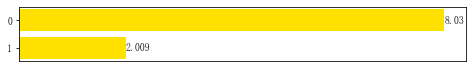

In [6]:
from maysics.explain import Lime
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

lime = Lime(f)
# 默认邻域范围为0.1，新数据大小集为100，
lime.fit([2, 1], random_state=100)

# 保留三位小数
lime.show(estimate=3)

### DEMO 3-4：绘制分类模型$f_{1}(x,y)=\frac{1}{1+e^{-x-y}}$，$f_{2}(x,y)=1-f_{1}(x,y)$在点$(-1,2)$附近的各特征贡献值图

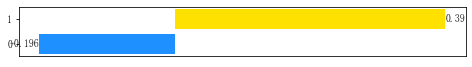

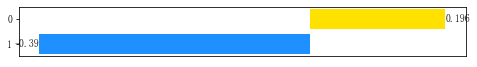

In [7]:
from maysics.explain import Lime
import numpy as np

def f(x):
    x = x[:, 0] + x[:, 1]
    x = 1 / (1 + np.e**(-x))
    return np.array([x, 1 - x]).T

lime = Lime(f)
lime.fit([-1, 2], random_state=100)
lime.show(estimate=3)

show函数和savefig函数仅支持表格数据的回归和分类模型的可视化

<br></br>
## SHAP值和Shapley值：SHAP和Shapley
使用与Lime类似
<br>SHAP(predict)
<br>Shapley(predict)
<br>```predict```是模型的预测函数


### SHAP和Shapley的方法
两个类都有三个方法：```fit```、```show```、```savefig```
<br>SHAP类和Shapley类仅适用于表格数据

### DEMO 4-1：求函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$的SHAP值

In [8]:
from maysics.explain import SHAP
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shap = SHAP(f)
shap.fit([1, 0])
shap.values

array([1., 0.])

### DEMO 4-2：绘制函数$f(x,y)=x^{2}+y^{2}$在点$(1,0)$的SHAP值

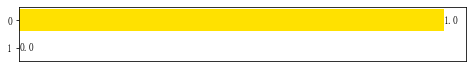

In [9]:
from maysics.explain import SHAP
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shap = SHAP(f)
shap.fit([1, 0])
shap.show()

### DEMO 4-3：求函数$f(x,y)=x^{2}+y^{2}$在点集${(1,0),(2,1)}$的Shapley值

In [10]:
from maysics.explain import Shapley
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shapley = Shapley(f)
shapley.fit([[1, 0], [2, 1]])
shapley.values

array([2.5, 0.5])

### DEMO 4-4：绘制函数$f(x,y)=x^{2}+y^{2}$在点集${(1,0),(2,1)}$的Shapley值

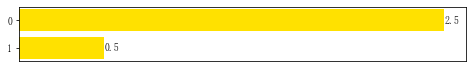

In [11]:
from maysics.explain import Shapley
import numpy as np

# 仅支持小批量输入函数
def f(x):
    x = np.array(x)
    return x[:, 0]**2 + x[:, 1]**2

shapley = Shapley(f)
shapley.fit([[1, 0], [2, 1]])
shapley.show()

本模块中的以上两种解释方法：SHAP和Shapley，目前只能解释有一个预测值的回归模型